<h1>Classification</h1>

<h2 align="center">Decision Trees</h2><h3>Paremeters study</h3>

Train#=30732 Test#=13172
Labels=[0. 1.]
entropy
2
4
6
8
10
12
14
16
18
20
22
24
gini
2
4
6
8
10
12
14
16
18
20
22
24
DT best with entropy and d=10


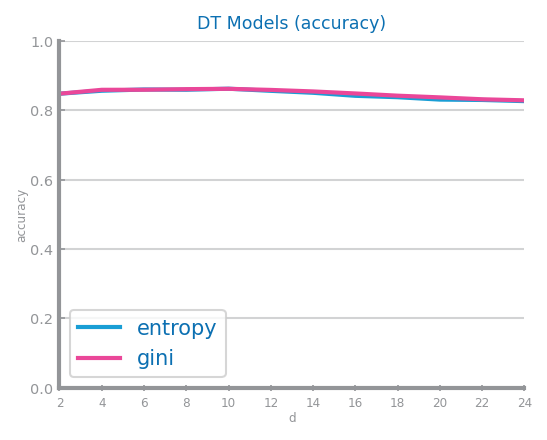

In [1]:
from typing import Literal
from numpy import array, ndarray
from matplotlib.pyplot import figure, savefig, show
from sklearn.tree import DecisionTreeClassifier
from dslabs_functions import CLASS_EVAL_METRICS, DELTA_IMPROVE, read_train_test_from_files
from dslabs_functions import plot_evaluation_results, plot_multiline_chart


def trees_study(
        trnX: ndarray, trnY: array, tstX: ndarray, tstY: array, d_max: int=24, lag:int=2, metric='accuracy'
        ) -> tuple:
    criteria: list[Literal['entropy', 'gini']] = ['entropy', 'gini']
    depths: list[int] = [i for i in range(2, d_max+1, lag)]

    best_model: DecisionTreeClassifier | None = None
    best_params: dict = {'name': 'DT', 'metric': metric, 'params': ()}
    best_performance: float = 0.0

    values: dict = {}
    for c in criteria:
        print(c)
        y_tst_values: list[float] = []
        for d in depths:
            print(d)
            clf = DecisionTreeClassifier(max_depth=d, criterion=c, min_impurity_decrease=0)
            clf.fit(trnX, trnY)
            prdY: array = clf.predict(tstX)
            eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
            y_tst_values.append(eval)
            if eval - best_performance > DELTA_IMPROVE:
                best_performance = eval
                best_params['params'] = (c, d)
                best_model = clf
            # print(f'DT {c} and d={d}')
        values[c] = y_tst_values
    print(f'DT best with {best_params['params'][0]} and d={best_params['params'][1]}')
    plot_multiline_chart(depths, values, title=f'DT Models ({metric})', xlabel='d', ylabel=metric, percentage=True)

    return best_model, best_params

file_tag = 'credit_score'
train_filename = '../../../data/class_credit_score_train.csv'
test_filename = '../../../data/class_credit_score_test.csv'
target = 'Credit_Score'
eval_metric = 'accuracy'

trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train_filename, test_filename, target)
print(f'Train#={len(trnX)} Test#={len(tstX)}')
print(f'Labels={labels}')

figure()
best_model, params = trees_study(trnX, trnY, tstX, tstY, d_max=25, metric=eval_metric)
savefig(f'../../../images/{file_tag}_dt_{eval_metric}_study.png')
show()

<h3>Best model performance</h3>

<Figure size 600x450 with 0 Axes>

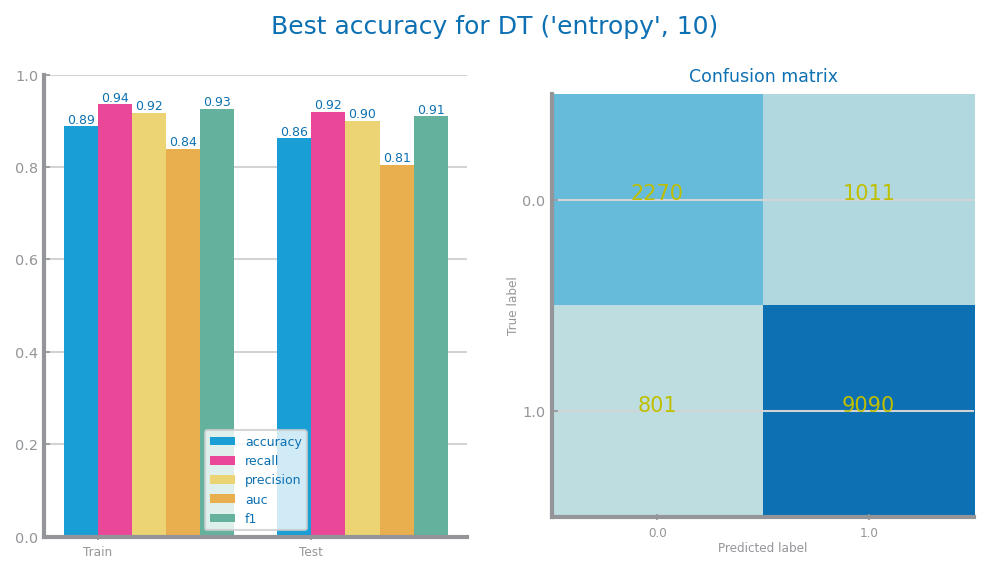

In [2]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'../../../images/{file_tag}_dt_{params["name"]}_best_{params["metric"]}_eval.png')
show()

<h3>Variables importance</h3>

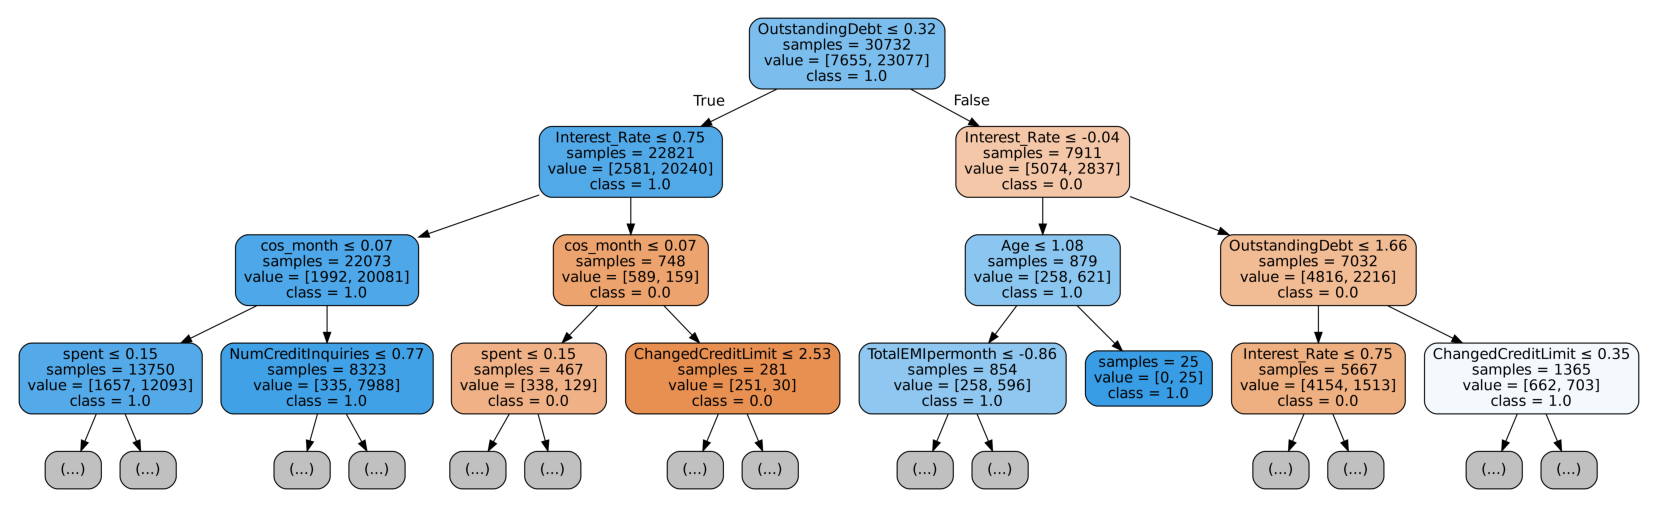

In [3]:
from sklearn.tree import export_graphviz
from matplotlib.pyplot import imread, imshow, axis
from subprocess import call

tree_filename: str = f"../../../images/{file_tag}_dt_{eval_metric}_best_tree"
max_depth2show = 3
st_labels: list[str] = [str(value) for value in labels]

dot_data: str = export_graphviz(
    best_model,
    out_file=tree_filename + ".dot",
    max_depth=max_depth2show,
    feature_names=vars,
    class_names=st_labels,
    filled=True,
    rounded=True,
    impurity=False,
    special_characters=True,
    precision=2,
)
# Convert to png
call(
    ["dot", "-Tpng", tree_filename + ".dot", "-o", tree_filename + ".png", "-Gdpi=600"]
)

figure(figsize=(14, 6))
imshow(imread(tree_filename + ".png"))
axis("off")
show()

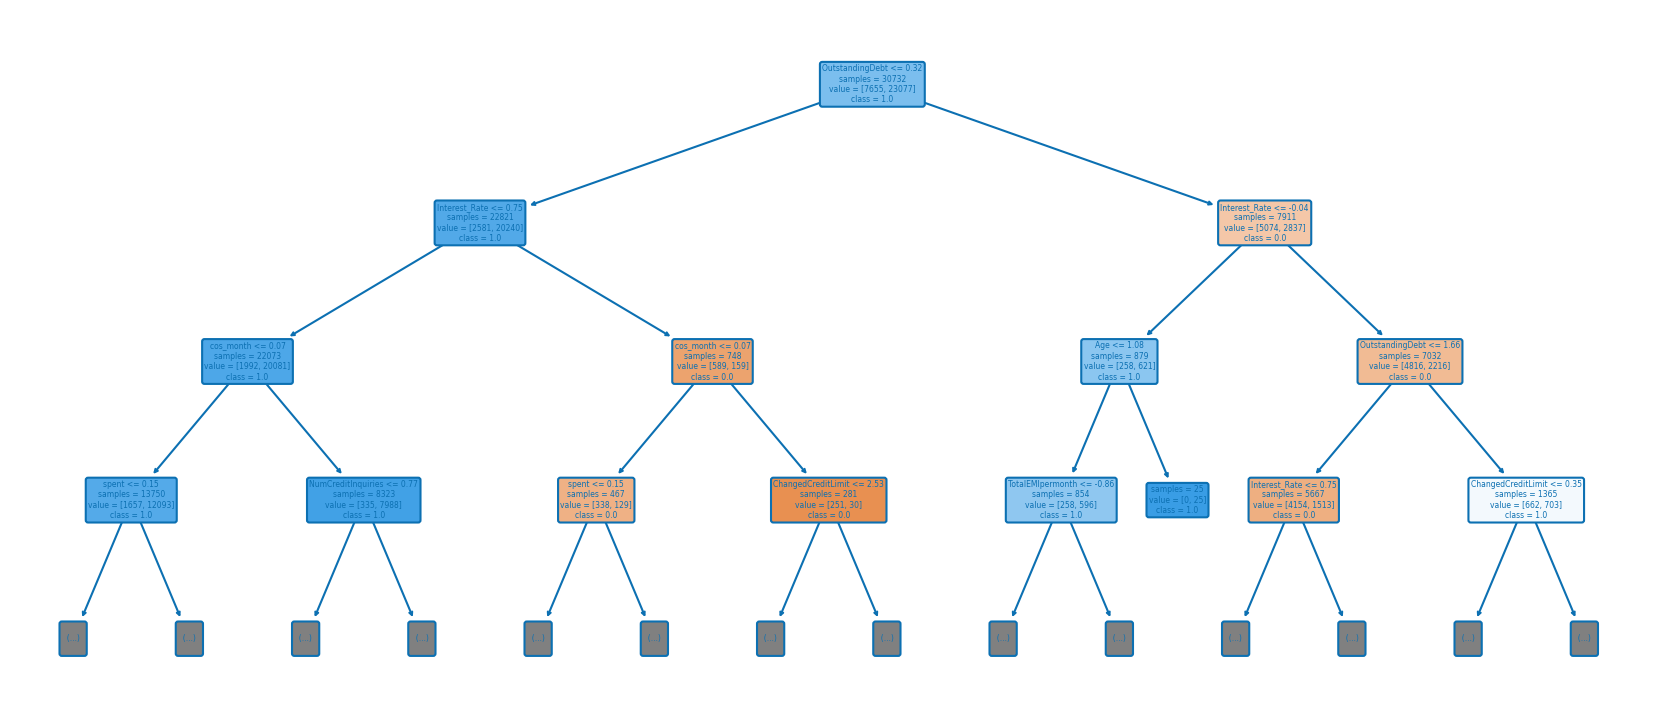

In [4]:
from sklearn.tree import plot_tree

figure(figsize=(14, 6))
plot_tree(
    best_model,
    max_depth=max_depth2show,
    feature_names=vars,
    class_names=st_labels,
    filled=True,
    rounded=True,
    impurity=False,
    precision=2,
)
savefig(tree_filename + ".png")

1. OutstandingDebt (0.5250733970167286)
2. Interest_Rate (0.1726718103802459)
3. cos_month (0.032151636749398)
4. ChangedCreditLimit (0.025473075808331035)
5. NumCreditInquiries (0.025447220396843634)
6. ID (0.020832228015746086)
7. Annual_Income (0.020617518288134573)
8. Delay_from_due_date (0.019877656435840534)
9. Num_Bank_Accounts (0.016524585888912813)
10. MonthlyBalance (0.015338379623913224)
11. NumofDelayedPayment (0.01463800934132133)
12. TotalEMIpermonth (0.013965991580273207)
13. Credit_History_Age (0.01343084975295244)
14. Age (0.01252191729966322)
15. Amountinvestedmonthly (0.009156405535800743)
16. Occupation (0.008510538958339286)
17. CreditUtilizationRatio (0.007387430454908471)
18. Monthly_Inhand_Salary (0.007190339255514165)
19. spent (0.00681206803163866)
20. sin_month (0.005511998934207628)
21. Payment_of_Min_Amount (0.0044462852907039855)
22. value_payments (0.003906865745335481)
23. PersonalLoan (0.003024571125983286)
24. NumofLoan (0.0029011397589385523)
25. Stud

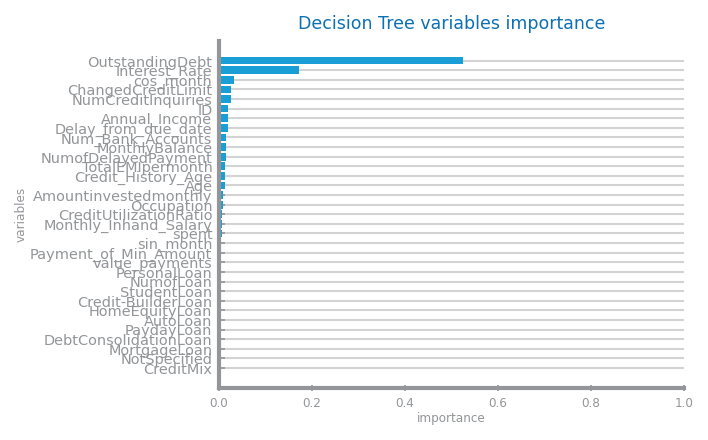

In [5]:
from numpy import argsort
from dslabs_functions import plot_horizontal_bar_chart

importances = best_model.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values += [importances[indices[f]]]
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    title="Decision Tree variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"../../../images/{file_tag}_dt_{eval_metric}_vars_ranking.png", bbox_inches='tight')

<h3>Overfitting study</h3>

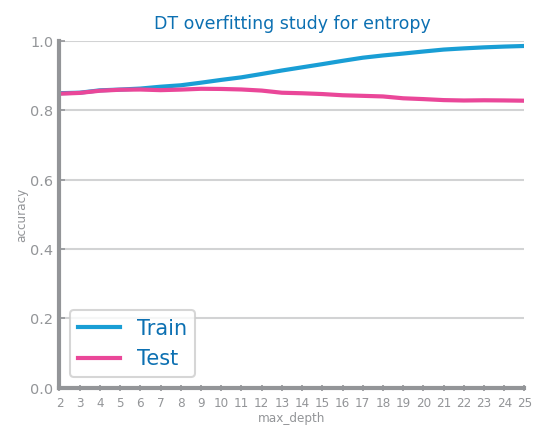

In [8]:
crit: Literal["entropy", "gini"] = params["params"][0]
d_max = 25
depths: list[int] = [i for i in range(2, d_max + 1, 1)]
y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric = "accuracy"
for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, criterion=crit, min_impurity_decrease=0)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    depths,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"DT overfitting study for {crit}",
    xlabel="max_depth",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"../../../images/{file_tag}_dt_{eval_metric}_overfitting.png")